#Imports

In [69]:
!pip install matplotlib==2.0.2

     |████████████████████████████████| 14.6MB 216kB/s 
ERROR: seaborn 0.10.0 has requirement matplotlib>=2.1.2, but you'll have matplotlib 2.0.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.0.2 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.0.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1


In [0]:
import torch
from torchvision import transforms, models
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [0]:
from tqdm import tqdm_notebook

# Device

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [12]:
print(device)

cuda:0


In [4]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

# Download pretrained vgg

In [184]:
model = models.vgg19(pretrained=True).features
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
for p in model.parameters():
  p.requires_grad=False
model = model.to(device)

# Necessary steps

In [9]:
for name,layer in model._modules.items():
  print(name, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

In [0]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

In [0]:
transform = transforms.Compose([transforms.Resize(400),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                             std=(0.5, 0.5, 0.5))])

In [231]:
content = Image.open('./content1.jpeg').convert("RGB")
content = transform(content).to(device)
print("Content shape => ", content.shape)
style = Image.open("./style.jpg").convert("RGB")
style = transform(style).to(device)

Content shape =>  torch.Size([3, 711, 400])


In [0]:
#Show images
def image_show(image):
  x = image.to('cpu').clone().detach().numpy().squeeze()
  x = x.transpose(1,2,0)
  x = (x - np.min(x)) / (np.max(x) - np.min(x))
  #x = x / 2 + 0.5
  #x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  return x

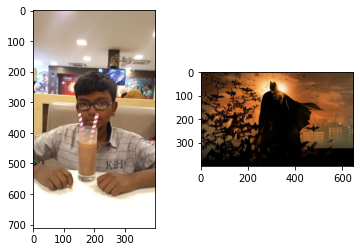

In [232]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image_show(content), label='content')
ax2.imshow(image_show(style), label='style')

In [0]:
#Compute gram matrix
def gram_matrix(imgFeatures):
  _,d,h,w = imgFeatures.size()
  imgFeatures = imgFeatures.view(d,h*w)
  gram_mat = torch.mm(imgFeatures,imgFeatures.t())
  return gram_mat

In [0]:
style_features = model_activations(style,model)
content_features = model_activations(content,model)

target = content.clone().requires_grad_(True).to(device)

style_wt_meas = {"conv1_1" : 0.4, 
                 "conv2_1" : 0.3,
                 "conv3_1" : 0.2,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

content_wt = 1000
style_wt = 1e8

print_after = 100
epochs = 1000
optimizer = torch.optim.Adam([target],lr=0.01)



# Training Loop

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


*** Epoch: 0 **** loss: 11595085688176902144.00


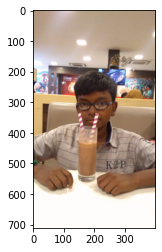

*** Epoch: 10 **** loss: 7998934447686680576.00
*** Epoch: 20 **** loss: 6573770565507612672.00
*** Epoch: 30 **** loss: 5610305909482848256.00
*** Epoch: 40 **** loss: 4854554393107759104.00
*** Epoch: 50 **** loss: 4232132680373764096.00
*** Epoch: 60 **** loss: 3702598534588006400.00
*** Epoch: 70 **** loss: 3252195416019566592.00
*** Epoch: 80 **** loss: 2866977668937547776.00
*** Epoch: 90 **** loss: 2536083767726964736.00
*** Epoch: 100 **** loss: 2248572884496678912.00


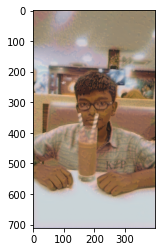

*** Epoch: 110 **** loss: 1994728634992033792.00
*** Epoch: 120 **** loss: 1767978138702184448.00
*** Epoch: 130 **** loss: 1567773151641731072.00
*** Epoch: 140 **** loss: 1394863678179770368.00
*** Epoch: 150 **** loss: 1248276238208860160.00
*** Epoch: 160 **** loss: 1125446220857212928.00
*** Epoch: 170 **** loss: 1022561619311329280.00
*** Epoch: 180 **** loss: 936185428942258176.00
*** Epoch: 190 **** loss: 863358589081747456.00
*** Epoch: 200 **** loss: 801654889884155904.00


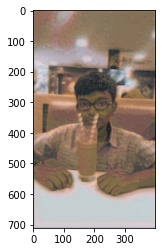

*** Epoch: 210 **** loss: 749151285512503296.00
*** Epoch: 220 **** loss: 704346461558538240.00
*** Epoch: 230 **** loss: 665919698398871552.00
*** Epoch: 240 **** loss: 632771140808343552.00
*** Epoch: 250 **** loss: 603912877589397504.00
*** Epoch: 260 **** loss: 578404070386040832.00
*** Epoch: 270 **** loss: 555622807933812736.00
*** Epoch: 280 **** loss: 535353104917331968.00
*** Epoch: 290 **** loss: 517387462876594176.00
*** Epoch: 300 **** loss: 501351738620510208.00


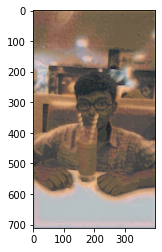

*** Epoch: 310 **** loss: 486985210454343680.00
*** Epoch: 320 **** loss: 474116698161545216.00
*** Epoch: 330 **** loss: 462582580668006400.00
*** Epoch: 340 **** loss: 452313348223008768.00
*** Epoch: 350 **** loss: 443170909038051328.00
*** Epoch: 360 **** loss: 434973122140045312.00
*** Epoch: 370 **** loss: 427540767133663232.00
*** Epoch: 380 **** loss: 420776743398277120.00
*** Epoch: 390 **** loss: 414577525042184192.00
*** Epoch: 400 **** loss: 408902430135156736.00


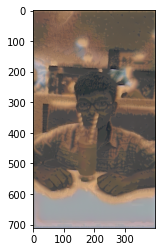

*** Epoch: 410 **** loss: 403729227926470656.00
*** Epoch: 420 **** loss: 398980952602181632.00
*** Epoch: 430 **** loss: 394589709319274496.00
*** Epoch: 440 **** loss: 390498701430226944.00
*** Epoch: 450 **** loss: 386685010989547520.00
*** Epoch: 460 **** loss: 383112903869333504.00
*** Epoch: 470 **** loss: 379746474142990336.00
*** Epoch: 480 **** loss: 376597266682609664.00
*** Epoch: 490 **** loss: 373672119076126720.00
*** Epoch: 500 **** loss: 370952030388224000.00


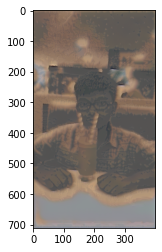

*** Epoch: 510 **** loss: 368421813614542848.00
*** Epoch: 520 **** loss: 366082602626449408.00
*** Epoch: 530 **** loss: 363921065845456896.00
*** Epoch: 540 **** loss: 361927719983775744.00
*** Epoch: 550 **** loss: 360086278525419520.00
*** Epoch: 560 **** loss: 358390762875912192.00
*** Epoch: 570 **** loss: 356824714720575488.00
*** Epoch: 580 **** loss: 355376039431503872.00
*** Epoch: 590 **** loss: 354034291648233472.00
*** Epoch: 600 **** loss: 352777927814807552.00


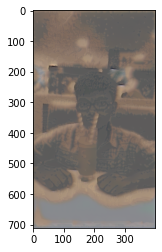

*** Epoch: 610 **** loss: 351616396859277312.00
*** Epoch: 620 **** loss: 350541899121033216.00
*** Epoch: 630 **** loss: 349534368512868352.00
*** Epoch: 640 **** loss: 348582122723737600.00
*** Epoch: 650 **** loss: 347686467423698944.00
*** Epoch: 660 **** loss: 346843485602578432.00
*** Epoch: 670 **** loss: 346052696224038912.00
*** Epoch: 680 **** loss: 345305578072965120.00
*** Epoch: 690 **** loss: 344595980756189184.00
*** Epoch: 700 **** loss: 343921739610193920.00


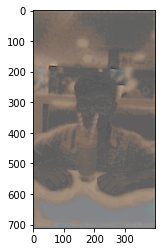

*** Epoch: 710 **** loss: 343278731466375168.00
*** Epoch: 720 **** loss: 342663108034035712.00
*** Epoch: 730 **** loss: 342078889402564608.00
*** Epoch: 740 **** loss: 341521024690421760.00
*** Epoch: 750 **** loss: 340990407250804736.00
*** Epoch: 760 **** loss: 340497138846793728.00
*** Epoch: 770 **** loss: 340031701830860800.00
*** Epoch: 780 **** loss: 339599147084546048.00
*** Epoch: 790 **** loss: 339184837359304704.00
*** Epoch: 800 **** loss: 338787260826648576.00


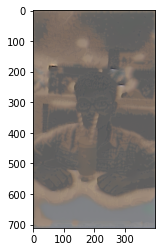

*** Epoch: 810 **** loss: 338414732543262720.00
*** Epoch: 820 **** loss: 338056566630514688.00
*** Epoch: 830 **** loss: 337713519002648576.00
*** Epoch: 840 **** loss: 337381260332630016.00
*** Epoch: 850 **** loss: 337065563056504832.00
*** Epoch: 860 **** loss: 336756497209884672.00
*** Epoch: 870 **** loss: 336459044954832896.00
*** Epoch: 880 **** loss: 336176023789895680.00
*** Epoch: 890 **** loss: 335904753655480320.00
*** Epoch: 900 **** loss: 335641970376441856.00


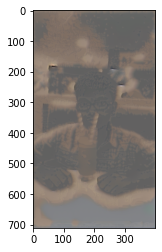

*** Epoch: 910 **** loss: 335389460659175424.00
*** Epoch: 920 **** loss: 335147190143942656.00
*** Epoch: 930 **** loss: 334911825936121856.00
*** Epoch: 940 **** loss: 334682165444870144.00
*** Epoch: 950 **** loss: 334459170742861824.00
*** Epoch: 960 **** loss: 334243700823556096.00
*** Epoch: 970 **** loss: 334034621815586816.00
*** Epoch: 980 **** loss: 333829081860669440.00
*** Epoch: 990 **** loss: 333627836873048064.00



In [234]:
for i in tqdm_notebook(range(epochs), total=epochs, unit='epoch/s'):
  target_features = model_activations(target, model)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  style_loss = 0
  for layer in style_wt_meas:
    style_gram = style_grams[layer]
    target_feature = target_features[layer]
    _,d,h,w = target_feature.size()
    target_gram = gram_matrix(target_feature)
    style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h

  total_loss = content_wt*content_loss + style_wt*style_loss

  if i % 10 == 0:
    print("*** Epoch: %d **** loss: %0.2f"%(i,total_loss))
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i%print_after == 0:
        img = target.clone().squeeze()
        plt.imshow(image_show(target),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.jpg',image_show(target),format='jpg')